# Detector de estrellas candidatas a HVS
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

### Requirements

In [39]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.project_vars import SELECTED_CLUSTERS, PATH
from hyper_velocity_stars_detection.etls.catalogs import CatalogsType
from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.cluster_selection_job import download_data
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster, cluster_representation_with_hvs
from hyper_velocity_stars_detection.tools.cluster_detection import optimize_clustering, get_main_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
SELECTED_CLUSTERS

[Cluster(name='ngc 104', radio_scale=6, filter_parallax_max=1),
 Cluster(name='ngc 5139', radio_scale=6, filter_parallax_max=1),
 Cluster(name='ngc 6121', radio_scale=6, filter_parallax_max=1),
 Cluster(name='m 49', radio_scale=6, filter_parallax_max=1)]

In [40]:
cluster = SELECTED_CLUSTERS[0]
project = download_data(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 154362.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16353.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16353.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24125.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 1 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 2269
	 - Volumen total del cluster 0: 1175.
	 - Volumen

In [21]:
dfr1 = project.data_list[0].get_data("df_1_c2")
df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(dfr1, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cluster_representations.py:92: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isochrone = pd.read_csv(


(np.float64(12.994592875533943), np.float64(-0.16108173824371577))

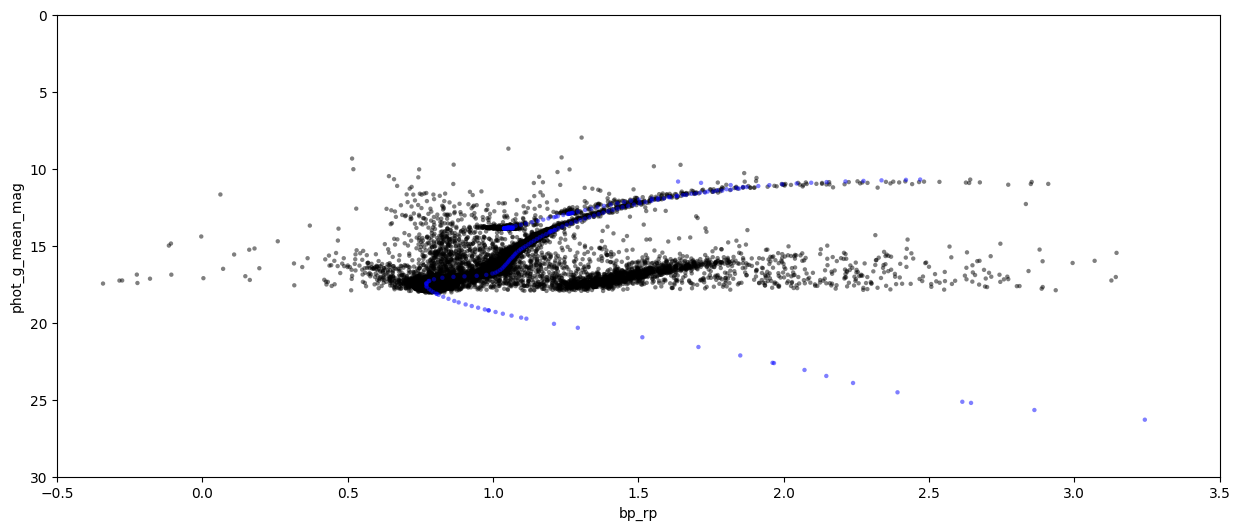

In [22]:
dfr1 = project.data_list[0].get_data("df_1_c1")

ax, fig = cmd_plot(dfr1, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                  )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

In [41]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
# clustering = project.cluster_detection(
#     data_name="df_1_c2",
#     columns=["pmra", "pmdec", "parallax"], 
#     columns_to_clus=columns_to_clus,
#     max_cluster=10,
#     method="dbscan",
#     n_trials=100
# )

print(str(project.clustering_results))

Estimated number of clusters: 3
Estimated number of noise points: 2269
	 - Volumen total del cluster 0: 1175.
	 - Volumen total del cluster 1: 12776.
	 - Volumen total del cluster 2: 14.



In [27]:
project.save_project(PATH)

In [18]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
clustering = optimize_clustering(
    df_stars=dfr1,
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="dbscan",
    n_trials=100
)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

for label in np.unique(labels[labels >-1]):
    mask_i = labels == label
    print(f"Volumen total del cluster {label}: %d" % mask_i.sum())


[I 2025-02-27 14:17:52,313] A new study created in memory with name: no-name-d2c6f54b-e6fe-4b9f-b731-c8deb72b9c06
[I 2025-02-27 14:17:54,641] Trial 0 finished with value: 3.6997422949227907 and parameters: {'eps': 0.7891953634390362, 'min_samples': 4}. Best is trial 0 with value: 3.6997422949227907.
[I 2025-02-27 14:17:56,908] Trial 1 finished with value: 3.47957547324635 and parameters: {'eps': 0.8110102020056605, 'min_samples': 7}. Best is trial 1 with value: 3.47957547324635.
[I 2025-02-27 14:17:59,051] Trial 2 finished with value: 3.3017516039517 and parameters: {'eps': 0.7484875200158002, 'min_samples': 7}. Best is trial 2 with value: 3.3017516039517.
[I 2025-02-27 14:18:00,819] Trial 3 finished with value: 22.558292089584636 and parameters: {'eps': 0.3629467202071638, 'min_samples': 4}. Best is trial 2 with value: 3.3017516039517.
[I 2025-02-27 14:18:02,928] Trial 4 finished with value: 3.0429820412767357 and parameters: {'eps': 0.652933416763027, 'min_samples': 8}. Best is trial

Estimated number of clusters: 3
Estimated number of noise points: 2253
Volumen total del cluster 0: 1174
Volumen total del cluster 1: 12793
Volumen total del cluster 2: 14


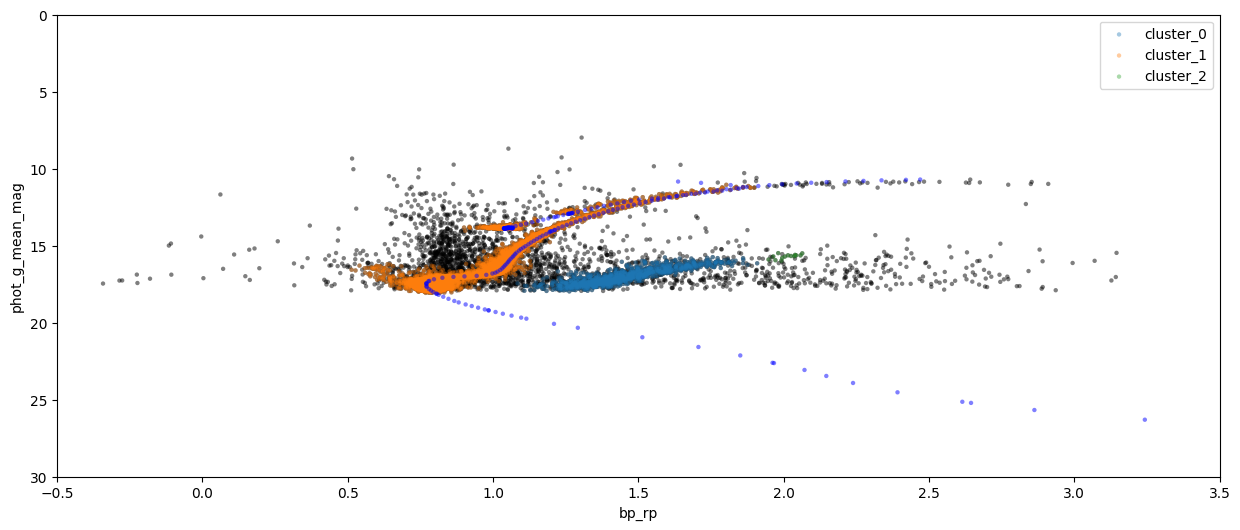

In [20]:
mask_nan = dfr1[columns_to_clus].isna().any(axis=1).values
data = dfr1[~mask_nan]

ax, fig = cmd_with_cluster(data, labels, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                          )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.legend()
plt.show()

In [21]:
mask = labels == get_main_cluster(labels)
gc = data[mask]

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax"]].describe())

Número de estrellas de CLuster seleccionado: 12793
Número de HVS del CLuster seleccionado: 2497


,pmra,pmdec,parallax
count,12793.000000,12793.000000,12793.000000
mean,5.251767,-2.574015,0.195428
std,0.375141,0.385067,0.078098
min,3.059615,-4.270577,-0.227476
25%,5.006567,-2.840726,0.153685
50%,5.249786,-2.579028,0.195665
75%,5.493950,-2.306874,0.235842
max,7.356507,-0.871430,0.613731


In [30]:
gc.columns.values

array(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_params_solved', 'astrometric_primary_flag',
       'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error',
       'ra_pseudocolour_corr', 'dec_pseudocolour_corr',
       'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr',
       'pmdec_pseudocolour_corr', 'astrometric_matche

In [32]:
display(gc[["pm_l", "pm_b", "parallax"]].describe())

,pm_l,pm_b,parallax
count,12793.000000,12793.000000,12793.000000
mean,3.791369,-4.453328,0.195428
std,0.386318,0.373853,0.078098
min,1.602111,-6.408937,-0.227476
25%,3.534663,-4.708519,0.153685
50%,3.788556,-4.452645,0.195665
75%,4.046241,-4.200364,0.235842
max,6.171719,-2.655984,0.613731


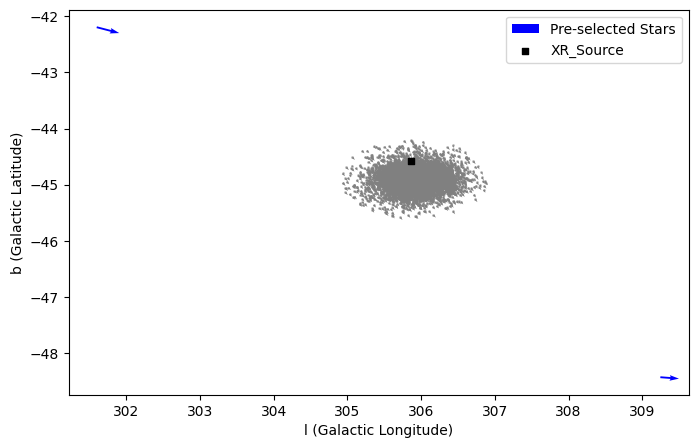

In [36]:
# Representar en el diagrama CMD la estrella candidata de hipervelocidad.

dfr6 = project.data_list[1].get_data("df_6_c3")

fig, ax = cluster_representation_with_hvs(gc, dfr6, hvs_pm=30, df_source_x=project.xsources)
plt.show()

## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.